### Feature Engineering
В этом блокноте нужно постараться построить такие признаки из имеющихся, чтобы восстанавливаемая закономерность была максимально выразительна. Предполагается, что данные провалидированы, их структура уже известна и имеются некоторые представления о том, как данные распределены

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib
import sklearn

from sklearn.feature_selection import SelectKBest, SelectFpr, chi2, f_classif, VarianceThreshold, SelectFromModel, RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

%matplotlib inline
from matplotlib import pyplot as plot

from modules.utils import print_versions, unpickle
from modules.transformers import TimesTransformer, NansCountImputer, DomainsExtractor, DomainsCountImputer, DomainsVectorizer, DomainsSplitter

In [2]:
print_versions([ np, scipy, pd, matplotlib, sklearn ])

Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
 -  numpy 1.18.1
 -  scipy 1.3.2
 -  pandas 1.0.0
 -  matplotlib 3.1.2
 -  sklearn 0.22.1


In [3]:
sites = unpickle('./data/site_dic.pkl')
sites = { value: key for (key, value) in sites.items() }

target_column = 'target'
site_columns = [ 'site{}'.format(i) for i in range(1, 11) ]
time_columns = [ 'time{}'.format(i) for i in range(1, 11) ]

dtype = { c: np.float for c in site_columns }
sessions = pd.read_csv('./data/train_sessions.csv', index_col='session_id', dtype=dtype, parse_dates=time_columns)

__Отделим фиксированную выборку для изучения, чтобы далее протестировать сделанные по ней выводы на "переобучение"__

In [4]:
print('Sessions count before split:', sessions.shape[0])

for (target, count) in enumerate(sessions[target_column].value_counts()):
    print('Sessions with target {} amount to {} of all sessions'.format(target, round(count / sessions.shape[0], 3)))
    
sessions, _ = train_test_split(sessions, test_size=.3, stratify=sessions[target_column], random_state=42)

print('Sessions count after split:', sessions.shape[0])

for (target, count) in enumerate(sessions[target_column].value_counts()):
    print('Sessions with target {} amount to {} of all sessions'.format(target, round(count / sessions.shape[0], 3)))

Sessions count before split: 253561
Sessions with target 0 amount to 0.991 of all sessions
Sessions with target 1 amount to 0.009 of all sessions
Sessions count after split: 177492
Sessions with target 0 amount to 0.991 of all sessions
Sessions with target 1 amount to 0.009 of all sessions


__Преобразуем все временные признаки с помощью TimesTransformer и NansCountImputer__

Первое время каждой сессии TimesTransformer раскладывает на:
* номер года
* дельту дней между временем и началом года
* дельту дней между временем и началом недели
* дельту секунд с полуночи

Затем TimesTransformer считает дельты между последующим и текущим временем, сохраняя nan, там где время не указано.

Такое преобразование было подобрано в соответствии с исследованием временых признаков на первом шаге и позволяет сохранить сезонность, ярко выраженную, как в масштабе года, так и в масштабе недель и дней.

Количество nan признаков также может оказаться полезным, поэтому добавим соответствующий признак c помощью NansCountImputer.

In [5]:
sessions_times_columns = [
    'year',
    'days_since_year_start',
    'days_since_week_start',
    'seconds_since_midnight',
    *[ 'seconds_before_time_{}'.format(i + 1) for i in range(1, len(time_columns)) ],
    'nans_count'
]

sessions_times = TimesTransformer().fit_transform(sessions[time_columns].to_numpy())
sessions_times = NansCountImputer().fit_transform(sessions_times)
sessions_times = pd.DataFrame(sessions_times, sessions.index, sessions_times_columns)

sessions_times[sessions_times.columns[:8]].describe()

,year,days_since_year_start,days_since_week_start,seconds_since_midnight,seconds_before_time_2,seconds_before_time_3,seconds_before_time_4,seconds_before_time_5
count,177492.000000,177492.000000,177492.000000,177492.000000,175067.000000,172833.000000,171027.000000,169310.000000
mean,2013.705463,123.734056,2.291348,46034.032080,19.218442,19.603108,18.027972,15.903691
std,0.455836,113.384951,1.611727,11337.373133,99.771583,107.715861,95.401051,80.889476
min,2013.000000,1.000000,0.000000,27444.000000,0.000000,0.000000,0.000000,0.000000
25%,2013.000000,49.000000,1.000000,36767.000000,0.000000,0.000000,0.000000,0.000000
50%,2014.000000,79.000000,2.000000,44514.500000,1.000000,1.000000,1.000000,1.000000
75%,2014.000000,118.000000,4.000000,54147.250000,4.000000,4.000000,4.000000,4.000000
max,2014.000000,364.000000,6.000000,86380.000000,1800.000000,1800.000000,1799.000000,1798.000000


In [6]:
sessions_times[sessions_times.columns[8:]].describe()

,seconds_before_time_6,seconds_before_time_7,seconds_before_time_8,seconds_before_time_9,seconds_before_time_10,nans_count
count,167677.000000,166114.000000,164652.000000,163159.000000,161745.000000,177492.000000
mean,15.406412,14.992589,14.485855,14.395669,13.960432,0.483650
std,77.388300,75.311319,72.959922,72.763172,69.660122,1.735451
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,1768.000000,1795.000000,1781.000000,1765.000000,1785.000000,9.000000


__Как видно из статистик, интервалы времени между посещениями сайтов после первого, во-первых, выглядят довольно таки схоже, а во-вторых, группируются в нуле и имеют очень длинный и относительно равномерный хвост__

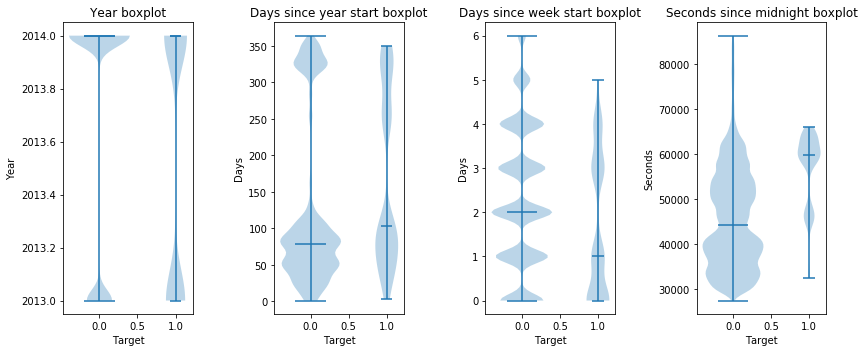

In [7]:
def filter_na(a):
    return [ e for e in a if not np.isnan(e) ]

targets = [0, 1]
sessions_times_by_target = [ sessions_times[sessions[target_column] == t] for t in targets ]

figure, axes = plot.subplots(1, 4, figsize=(12, 5), clear=True)
figure.suptitle('')

for i in range(0, 4):
    column = sessions_times.columns[i]
    
    ylabel = column.split('_')[0].capitalize()
    title = ' '.join(column.split('_')).capitalize()
    
    axes[i].violinplot([ filter_na(sessions[column].to_numpy()) for sessions in sessions_times_by_target ], positions=targets, widths=[ .8, .3 ], showmedians=True)
    axes[i].set(title='{} boxplot'.format(title), xlabel='Target', ylabel=ylabel)

plot.tight_layout()
plot.show()

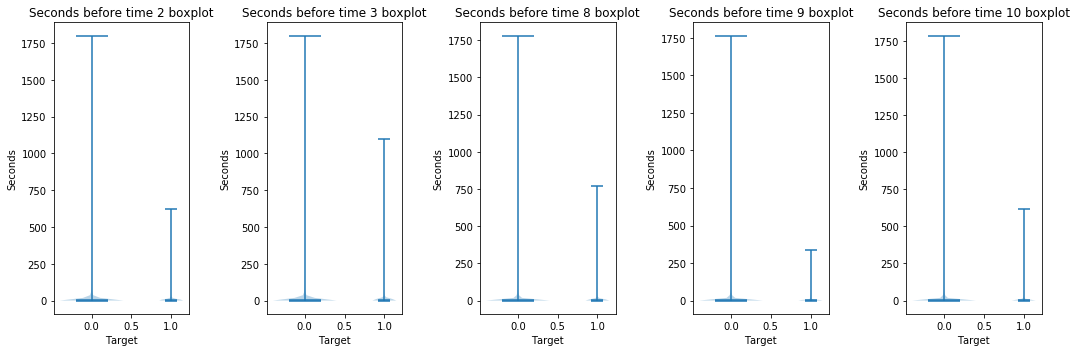

In [8]:
figure, axes = plot.subplots(1, 5, figsize=(15, 5), clear=True)
figure.suptitle('')

for (i, column_i) in enumerate([ 4, 5, -4, -3, -2 ]):
    column = sessions_times.columns[column_i]
    
    ylabel = column.split('_')[0].capitalize()
    title = ' '.join(column.split('_')).capitalize()
    
    axes[i].violinplot([ filter_na(sessions[column].to_numpy()) for sessions in sessions_times_by_target ], positions=targets, widths=[ .8, .3 ], showmedians=True)
    axes[i].set(title='{} boxplot'.format(title), xlabel='Target', ylabel=ylabel)

plot.tight_layout()
plot.show()

__Выводы которые можно сделать по анализу временных рядов данных__

Видно, что, в целом, текущие временные признаки мало подходят для хорошего разделения классов, поскольку границы наиболее объемных частей распределений сильно накладываются друг на друга для разных значениях целевой переменной. Но какую-то пользу из этого все равно можно постараться извлечь. Кроме того, те временные значения которые изначально показались выбросами, на самом деле неплохо отделяют один класс от другого.

Существует семейство алгоритмов классификации, которые слабо чувствительны к большим разрбросам в данных, могут находить нелинейные зависимости, легко интерпретируются и, к тому же, достаточно просты по своей сути - решающие деревья. Но они легко переобучаются, поэтому часто их объединяют в особый ансамбль - случайный лес, для уменьшения разброса.

Для отбора полезных признаков можно извлечь оценку их вклада в разделение выборок из обученного решающего дерева

In [9]:
def draw_prc(classifier, X, y, title=None):
    (precision, recall, _) = precision_recall_curve(y, classifier.predict_proba(X)[:, 1])

    precision_baseline = [ np.mean(y) ] * len(recall)
    
    if title:
        title = 'Precision recall curve for {}'.format(title.lower())

    plot.plot(recall, precision, label='Classifier precision recall curve')
    plot.plot(recall, precision_baseline, label='Precision baseline')
    plot.xlabel('Recall')
    plot.ylabel('Precision')
    plot.legend()
    plot.title(title)
    plot.show()


def summarize_classifier(classifier, X, y, title=None):
    print('{} summary'.format(title.capitalize()))
    print()
    print('Best parameters', classifier.best_params_)
    print()
    
    for score_name in [ 'f1', 'precision', 'recall', 'roc_auc' ]:
        result_key = 'mean_train_{}'.format(score_name)
        
        if result_key in classifier.cv_results_:
            score_value = round(classifier.cv_results_[result_key][classifier.best_index_], 3)
            print('Best train {}: {}'.format(score_name, score_value))
            
        result_key = 'mean_test_{}'.format(score_name)
            
        if result_key in classifier.cv_results_:
            score_value = round(classifier.cv_results_[result_key][classifier.best_index_], 3)
            print('Best cv test {}: {}'.format(score_name, score_value))
    
    print()
    draw_prc(classifier, X, y, title)

In [10]:
X = sessions_times.fillna(0).to_numpy()
y = sessions[target_column].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=42)

Random forest classifier based on time sequences data summary

Best parameters {'n_estimators': 94}

Best train f1: 1.0
Best cv test f1: 0.323
Best train precision: 1.0
Best cv test precision: 0.697
Best train recall: 0.999
Best cv test recall: 0.211
Best train roc_auc: 1.0
Best cv test roc_auc: 0.972



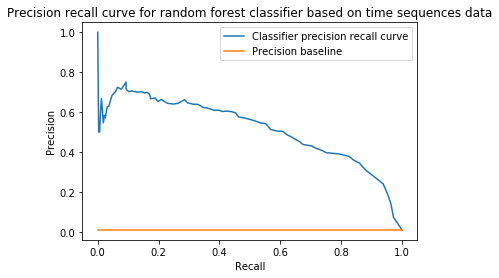

In [11]:
grid_search_kwargs = {
    'scoring' : [ 'roc_auc', 'f1', 'precision', 'recall' ],
    'refit' : 'f1',
    'return_train_score': True,
    'cv' : StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
    'param_grid' : {
        'n_estimators': [ *range(90, 111, 2) ]
    }
}

classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

classifier = GridSearchCV(classifier, n_jobs=4, **grid_search_kwargs).fit(X_train, y_train)

summarize_classifier(classifier, X_test, y_test, 'Random forest classifier based on time sequences data')

__Не самый плохой результат, с учетом того, что вся информация, которая используется при обучении - временные интервалы сессий. PRC - выше рандомного бейзлайна, а значит какая-то обобщающая информация случайным лесом все же извлекается. Небольшая площадь под PRC, в данном случае скорее следствие несбалансированности классов__

In [12]:
print('Significance of sessions times features derived from random forest information gain:')

for (column, importance) in zip(sessions_times.columns, classifier.best_estimator_.feature_importances_):
    print('{:<30} {}%'.format(column, round(importance * 100, 1)))

Significance of sessions times features derived from random forest information gain:
year                           2.8%
days_since_year_start          18.6%
days_since_week_start          13.0%
seconds_since_midnight         44.4%
seconds_before_time_2          2.3%
seconds_before_time_3          2.1%
seconds_before_time_4          2.0%
seconds_before_time_5          2.5%
seconds_before_time_6          2.3%
seconds_before_time_7          1.8%
seconds_before_time_8          2.0%
seconds_before_time_9          2.0%
seconds_before_time_10         2.0%
nans_count                     2.2%


__Наиболее важными признаками для правильной классификации являются количество дней с начала года и недели, а также количество секунд с начала дня__ 

Можно отобрать их с помощью feature селектора SelectFromModel

In [13]:
sessions_times_selector = SelectFromModel(classifier.best_estimator_, prefit=True, threshold=.02)
X_train = sessions_times_selector.transform(X_train)
X_test = sessions_times_selector.transform(X_test)

print('Significance of sessions times features selected from random forest:')

columns = np.take(sessions_times.columns, sessions_times_selector.get_support(True))

for (column, importance) in zip(columns, classifier.best_estimator_.feature_importances_):
    print('{:<30} {}%'.format(column, round(importance * 100, 1)))

Significance of sessions times features selected from random forest:
year                           2.8%
days_since_year_start          18.6%
days_since_week_start          13.0%
seconds_since_midnight         44.4%
seconds_before_time_2          2.3%
seconds_before_time_3          2.1%
seconds_before_time_4          2.0%
seconds_before_time_5          2.5%
seconds_before_time_6          2.3%
seconds_before_time_8          1.8%
nans_count                     2.0%


Random forest classifier based on time sequences data summary

Best parameters {'n_estimators': 100}

Best train f1: 1.0
Best cv test f1: 0.378
Best train precision: 1.0
Best cv test precision: 0.658
Best train recall: 1.0
Best cv test recall: 0.266
Best train roc_auc: 1.0
Best cv test roc_auc: 0.974



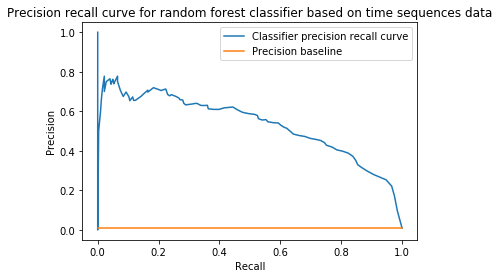

In [14]:
grid_search_kwargs = {
    'scoring' : [ 'roc_auc', 'f1', 'precision', 'recall' ],
    'refit' : 'f1',
    'return_train_score': True,
    'cv' : StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
    'param_grid' : {
        'n_estimators': [ *range(80, 121, 10) ]
    }
}

classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

classifier = GridSearchCV(classifier, n_jobs=4, **grid_search_kwargs).fit(X_train, y_train)

summarize_classifier(classifier, X_test, y_test, 'Random forest classifier based on time sequences data')

__Значение f1 чуть улучшилось__

__Пришло время добавить информацию о посещенных доменах__

Самый простой вариант, которым это можно сделать - с помощью простого подсчета доменов через DomainsCountImputer

In [15]:
sessions_sites = sessions[site_columns].to_numpy().astype('object')

for r in range(0, sessions_sites.shape[0]):
    for c in range(0, sessions_sites.shape[1]):
        if np.isnan(sessions_sites[r, c]):
            sessions_sites[r, c] = None
        else:
            sessions_sites[r, c] = sites[sessions_sites[r, c]]

In [16]:
X = sessions_times.fillna(0).to_numpy()
y = sessions[target_column].to_numpy()

imputer = DomainsCountImputer()
counts = imputer.fit_transform(sessions_sites)

X = np.hstack([ X, counts ])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=42)

Random forest classifier based on time sequences data and primitve domains counters summary

Best parameters {'n_estimators': 140}

Best train f1: 1.0
Best cv test f1: 0.396
Best train precision: 1.0
Best cv test precision: 0.734
Best train recall: 1.0
Best cv test recall: 0.271
Best train roc_auc: 1.0
Best cv test roc_auc: 0.979



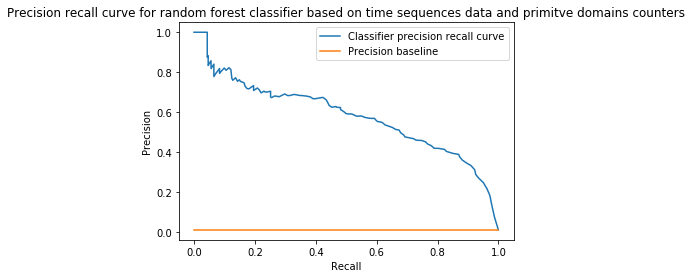

In [17]:
grid_search_kwargs = {
    'scoring' : [ 'roc_auc', 'f1', 'precision', 'recall' ],
    'refit' : 'f1',
    'return_train_score': True,
    'cv' : StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
    'param_grid' : {
        'n_estimators': [ *range(100, 201, 10) ]
    }
}

classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

classifier = GridSearchCV(classifier, n_jobs=4, **grid_search_kwargs).fit(X_train, y_train)

summarize_classifier(classifier, X_test, y_test, 'Random forest classifier based on time sequences data and primitve domains counters')

__Добавление этой информации также чуть улучшило f1 метрику__

Однако вряд ли этого достаточно. Чтобы еще улучшить метрики необходимо попытатся извлечь полезную информацию из посещенных доменов. Можно подисчитывать сколько раз тот или иной посещенный домен встречался в рамках одной сессии и попытаться классифицировать сессии на основе этой информации. Этот подход также известен как bag of words, но здесь мы применим его на уровне отдельных частей домена, разделенных точкой, поскольку даже такая раздробленная информация может оказаться полезной. Чтобы ограничить количество признаков разумных числом, можно рассматривать домены посещенные целевым пользователем. Их мало и существует вероятность, что среди них есть те домены, которые и выделяют этого пользователя.

Для осуществления этого были написаны два класса DomainsExtractor - читает строки из любой последовательности и дробит их, если они являются валидными доменами, а также DomainsVectorizer, который векторизует все домены из "словаря" и подсчитывает частоту каждого домена словаря для каждой сессии.

In [18]:
domains = DomainsExtractor().extract(sessions_sites[np.where(sessions[target_column].to_numpy() == 1)[0]])

vectorizer = DomainsVectorizer(domains)
sessions_sites_v = vectorizer.fit_transform(sessions_sites)

print('Count of vectorized domains:', sessions_sites_v.shape[1])

sessions_sites_v = VarianceThreshold().fit_transform(sessions_sites_v, sessions[target_column].to_numpy())

print('Count of vectorized domains after zero-variance feature reduction:', sessions_sites_v.shape[1])

Count of vectorized domains: 3191
Count of vectorized domains after zero-variance feature reduction: 3191


__Количество фич очень большое, но фичи эти примерно одной природы и вряд ли имеют большой разброс, поэтому можно попробовать применить к ним какой-нибудь достаточно простой алгоритм, по типу логистической регрессии. Что бы избежать недообучения, можно забустить его до достижения баланса между разбросом и смещением через валидацию__

In [19]:
X = sessions_sites_v
y = sessions[target_column].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=42)

Random forest classifier based on session domains data summary

Best parameters {'alpha': 0.0001, 'max_iter': 100}

Best train f1: 0.149
Best cv test f1: 0.126
Best train precision: 0.081
Best cv test precision: 0.068
Best train recall: 0.966
Best cv test recall: 0.814
Best train roc_auc: 0.975
Best cv test roc_auc: 0.932



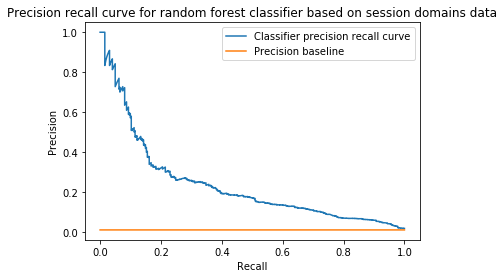

In [22]:
grid_search_kwargs = {
    'scoring' : [ 'roc_auc', 'f1', 'precision', 'recall' ],
    'refit' : 'f1',
    'return_train_score': True,
    
    'n_jobs': 4,
    'cv' : StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
    
    'param_grid' : {
        'alpha': [ 10e-5, 10e-4 ],
        'max_iter': [ 100, 105 ]
    }
}

classifier = SGDClassifier(loss='log', class_weight='balanced', random_state=42)
classifier = GridSearchCV(classifier, **grid_search_kwargs).fit(X_train, y_train)

summarize_classifier(classifier, X_test, y_test, 'Random forest classifier based on session domains data')

__Как видно, какую-то полезную информацию с помощью доменов все же получилось извлечь, хоть и несильно много__

__Пришло время построить пайплайн и посмотреть на его качество на следующем шаге__